# Testing Snowplow Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

Now reload all other modules for updated depot

In [23]:
import Snowplow_Routing_Middleton.dual_graphs as dual_graphs
import Snowplow_Routing_Middleton.construction as construction
import Snowplow_Routing_Middleton.plotting as plotting
import Snowplow_Routing_Middleton.local_search as local_search
import Snowplow_Routing_Middleton.initialize as initialize
import Snowplow_Routing_Middleton.params as params

from Snowplow_Routing_Middleton.shortest_paths import ShortestPaths
from Snowplow_Routing_Middleton.crossover import apply_crossover
from Snowplow_Routing_Middleton.genetic import run_genetic
from Snowplow_Routing_Middleton.solution import Solution
from Snowplow_Routing_Middleton.costs import routes_cost
from Snowplow_Routing_Middleton.routes_representations import create_full_routes_with_returns

import folium
import osmnx as ox
import networkx as nx
import datetime
import shapely
import numpy as np



In [17]:
approach = "genetic"
instance = "smallstreets"

G = initialize.create_small_streets()
DEPOT = params.find_depot(G)[0]
if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, DEPOT)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



Adding depot source 13


In [4]:
print(G)
print(G_DUAL)

MultiDiGraph with 51 nodes and 136 edges
MultiDiGraph with 137 nodes and 430 edges


In [5]:
sp = ShortestPaths(G_DUAL, False, False)

In [18]:
r, rreq = construction.route_generation(G, sp, DEPOT)


In [7]:
for route in r:
    for routestep in route:
        print(routestep)
    print("***")


13 --> 51. (0) Salt value: 20000. Prev: None. Next: None. Route end: False
51 --> 13. (0) Salt value: 19999.0. Prev: (13, 51, 0). Next: None. Route end: False
***
13 --> 30. (0) Salt value: 20000. Prev: None. Next: None. Route end: False
30 --> 22. (0) Salt value: 20000. Prev: (51, 13, 0). Next: None. Route end: False
22 --> 51. (0) Salt value: 19999.0. Prev: (30, 22, 0). Next: None. Route end: False
51 --> 22. (0) Salt value: 19998.0. Prev: (22, 51, 0). Next: None. Route end: False
22 --> 30. (0) Salt value: 19997.0. Prev: (51, 22, 0). Next: None. Route end: False
30 --> 48. (0) Salt value: 19996.0. Prev: (22, 30, 0). Next: None. Route end: False
48 --> 49. (0) Salt value: 19995.0. Prev: (30, 48, 0). Next: None. Route end: False
49 --> 48. (0) Salt value: 19994.0. Prev: (48, 49, 0). Next: None. Route end: False
48 --> 30. (0) Salt value: 19993.0. Prev: (49, 48, 0). Next: None. Route end: False
30 --> 13. (0) Salt value: 19992.0. Prev: (48, 30, 0). Next: None. Route end: False
***
13 -

In [8]:
for route in rreq:
    for routestep in route:
        print(routestep)
    print("**")

(13, 51, 0)
(51, 13, 0)
**
(30, 22, 0)
(22, 51, 0)
(51, 22, 0)
(22, 30, 0)
(30, 48, 0)
(48, 49, 0)
(49, 48, 0)
(48, 30, 0)
(30, 13, 0)
**
(51, 14, 0)
(14, 53, 0)
(53, 20, 1)
(20, 53, 0)
(53, 14, 0)
(14, 51, 0)
(22, 48, 0)
(48, 22, 0)
(48, 33, 0)
(33, 32, 0)
(32, 28, 1)
(28, 21, 0)
(21, 54, 0)
(54, 50, 0)
(50, 49, 0)
(49, 50, 0)
(50, 54, 0)
(21, 49, 0)
(49, 21, 0)
(21, 28, 0)
(28, 32, 0)
(32, 33, 1)
(33, 48, 0)
(33, 32, 1)
(32, 28, 0)
(28, 32, 1)
(32, 49, 0)
(32, 33, 0)
(33, 9, 0)
(9, 36, 0)
(36, 4, 0)
(4, 5, 0)
(5, 9, 0)
(9, 10, 0)
(10, 14, 0)
(14, 53, 1)
(53, 14, 1)
(14, 10, 0)
(10, 9, 0)
(10, 6, 0)
(6, 5, 0)
(5, 4, 0)
(4, 3, 0)
(3, 4, 0)
(4, 36, 0)
(36, 9, 0)
(10, 11, 0)
(11, 46, 0)
(46, 11, 0)
(11, 10, 0)
(14, 33, 0)
(14, 33, 1)
(36, 32, 0)
(5, 6, 0)
(6, 10, 0)
(6, 7, 0)
(7, 24, 0)
(24, 26, 0)
(26, 24, 0)
(24, 7, 0)
(7, 8, 0)
(8, 7, 0)
(7, 15, 0)
(15, 16, 0)
(16, 38, 0)
(38, 39, 0)
(39, 38, 0)
(38, 16, 0)
(16, 15, 0)
(15, 7, 0)
(7, 6, 0)
(6, 11, 0)
(11, 53, 0)
(53, 11, 0)
(46, 0, 0)

Test Local Search

In [9]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, DEPOT), 0)

print(routes_cost(G, sp, S_first.routes, DEPOT))
for route in S_first.routes:
    for routestep in route:
        print(routestep)
    print("**")

1541.8202750000003
(13, 51, 0)
(51, 13, 0)
**
(30, 22, 0)
(22, 51, 0)
(51, 22, 0)
(22, 30, 0)
(30, 48, 0)
(48, 49, 0)
(49, 48, 0)
(48, 30, 0)
(30, 13, 0)
**
(51, 14, 0)
(14, 53, 0)
(53, 20, 1)
(20, 53, 0)
(53, 14, 0)
(14, 51, 0)
(22, 48, 0)
(48, 22, 0)
(48, 33, 0)
(33, 32, 0)
(32, 28, 1)
(28, 21, 0)
(21, 54, 0)
(54, 50, 0)
(50, 49, 0)
(49, 50, 0)
(50, 54, 0)
(21, 49, 0)
(49, 21, 0)
(21, 28, 0)
(28, 32, 0)
(32, 33, 1)
(33, 48, 0)
(33, 32, 1)
(32, 28, 0)
(28, 32, 1)
(32, 49, 0)
(32, 33, 0)
(33, 9, 0)
(9, 36, 0)
(36, 4, 0)
(4, 5, 0)
(5, 9, 0)
(9, 10, 0)
(10, 14, 0)
(14, 53, 1)
(53, 14, 1)
(14, 10, 0)
(10, 9, 0)
(10, 6, 0)
(6, 5, 0)
(5, 4, 0)
(4, 3, 0)
(3, 4, 0)
(4, 36, 0)
(36, 9, 0)
(10, 11, 0)
(11, 46, 0)
(46, 11, 0)
(11, 10, 0)
(14, 33, 0)
(14, 33, 1)
(36, 32, 0)
(5, 6, 0)
(6, 10, 0)
(6, 7, 0)
(7, 24, 0)
(24, 26, 0)
(26, 24, 0)
(24, 7, 0)
(7, 8, 0)
(8, 7, 0)
(7, 15, 0)
(15, 16, 0)
(16, 38, 0)
(38, 39, 0)
(39, 38, 0)
(38, 16, 0)
(16, 15, 0)
(15, 7, 0)
(7, 6, 0)
(6, 11, 0)
(11, 53, 0)
(53

In [10]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, DEPOT, threshold=1)
print(routes_cost(G, sp, S_new.routes, DEPOT))
for route in S_new.routes:
    for routestep in route:
        print(routestep)
    print("***")

1497.7080849999998
(13, 51, 0)
(51, 13, 0)
(30, 22, 0)
(22, 51, 0)
(51, 22, 0)
(22, 30, 0)
(30, 48, 0)
(48, 49, 0)
(49, 48, 0)
(48, 30, 0)
(30, 13, 0)
(51, 14, 0)
(14, 53, 0)
(53, 20, 1)
(20, 53, 0)
(53, 14, 0)
(14, 51, 0)
(22, 48, 0)
(33, 48, 0)
(48, 33, 0)
(33, 32, 0)
(32, 28, 1)
(28, 21, 0)
(21, 54, 0)
(54, 50, 0)
(50, 49, 0)
(49, 50, 0)
(50, 54, 0)
(21, 49, 0)
(49, 21, 0)
(21, 28, 0)
(28, 32, 0)
(32, 33, 1)
(48, 22, 0)
(14, 33, 1)
(33, 32, 1)
(32, 28, 0)
(28, 32, 1)
(36, 32, 0)
(32, 49, 0)
(32, 33, 0)
(33, 9, 0)
(9, 36, 0)
(36, 4, 0)
(4, 5, 0)
(5, 9, 0)
(9, 10, 0)
(10, 14, 0)
(14, 53, 1)
(53, 14, 1)
(14, 10, 0)
(10, 9, 0)
(10, 6, 0)
(6, 5, 0)
(5, 4, 0)
(4, 3, 0)
(3, 4, 0)
(4, 36, 0)
(36, 9, 0)
(10, 11, 0)
(11, 46, 0)
(46, 11, 0)
(11, 10, 0)
(14, 33, 0)
(5, 6, 0)
(6, 10, 0)
(6, 7, 0)
(7, 24, 0)
(24, 7, 0)
(7, 8, 0)
(8, 7, 0)
(7, 15, 0)
(15, 16, 0)
(16, 38, 0)
(38, 39, 0)
(39, 38, 0)
(38, 16, 0)
(16, 15, 0)
(15, 7, 0)
(7, 6, 0)
(6, 11, 0)
(11, 53, 0)
(53, 11, 0)
(46, 0, 0)
(0, 41, 0)

In [11]:
for route in S_new.routes:
    for routestep in route:
        print(routestep)
    print("***")

(13, 51, 0)
(51, 13, 0)
(30, 22, 0)
(22, 51, 0)
(51, 22, 0)
(22, 30, 0)
(30, 48, 0)
(48, 49, 0)
(49, 48, 0)
(48, 30, 0)
(30, 13, 0)
(51, 14, 0)
(14, 53, 0)
(53, 20, 1)
(20, 53, 0)
(53, 14, 0)
(14, 51, 0)
(22, 48, 0)
(33, 48, 0)
(48, 33, 0)
(33, 32, 0)
(32, 28, 1)
(28, 21, 0)
(21, 54, 0)
(54, 50, 0)
(50, 49, 0)
(49, 50, 0)
(50, 54, 0)
(21, 49, 0)
(49, 21, 0)
(21, 28, 0)
(28, 32, 0)
(32, 33, 1)
(48, 22, 0)
(14, 33, 1)
(33, 32, 1)
(32, 28, 0)
(28, 32, 1)
(36, 32, 0)
(32, 49, 0)
(32, 33, 0)
(33, 9, 0)
(9, 36, 0)
(36, 4, 0)
(4, 5, 0)
(5, 9, 0)
(9, 10, 0)
(10, 14, 0)
(14, 53, 1)
(53, 14, 1)
(14, 10, 0)
(10, 9, 0)
(10, 6, 0)
(6, 5, 0)
(5, 4, 0)
(4, 3, 0)
(3, 4, 0)
(4, 36, 0)
(36, 9, 0)
(10, 11, 0)
(11, 46, 0)
(46, 11, 0)
(11, 10, 0)
(14, 33, 0)
(5, 6, 0)
(6, 10, 0)
(6, 7, 0)
(7, 24, 0)
(24, 7, 0)
(7, 8, 0)
(8, 7, 0)
(7, 15, 0)
(15, 16, 0)
(16, 38, 0)
(38, 39, 0)
(39, 38, 0)
(38, 16, 0)
(16, 15, 0)
(15, 7, 0)
(7, 6, 0)
(6, 11, 0)
(11, 53, 0)
(53, 11, 0)
(46, 0, 0)
(0, 41, 0)
(1, 44, 0)
(44, 45

In [12]:
s1, s1req = construction.route_generation(G, sp, DEPOT)
S1 = Solution(s1req, dict(), routes_cost(G, sp, s1req, DEPOT), 0)
S1 = local_search.local_improve(S1, G, sp, required_edges, DEPOT, threshold=1)

s2, s2req = construction.route_generation(G, sp, DEPOT)
S2 = Solution(s2req, dict(), routes_cost(G, sp, s2req, DEPOT), 0)
S2 = local_search.local_improve(S2, G, sp, required_edges, DEPOT, threshold=1)

In [13]:
S1.routes

[[(13, 51, 0),
  (51, 14, 0),
  (14, 53, 1),
  (53, 20, 0),
  (20, 42, 0),
  (1, 44, 0),
  (44, 0, 0),
  (0, 20, 0),
  (20, 53, 0),
  (53, 20, 1),
  (20, 53, 1),
  (53, 14, 0),
  (14, 51, 0),
  (51, 22, 0),
  (22, 48, 0),
  (48, 49, 0),
  (49, 50, 0),
  (50, 54, 0),
  (54, 50, 0),
  (50, 49, 0),
  (49, 21, 0),
  (21, 28, 0),
  (28, 32, 1),
  (32, 28, 1),
  (28, 21, 0),
  (21, 49, 0),
  (49, 48, 0),
  (48, 30, 0),
  (30, 13, 0),
  (22, 30, 0),
  (30, 22, 0),
  (22, 51, 0),
  (51, 13, 0),
  (30, 48, 0),
  (48, 22, 0),
  (48, 33, 0),
  (33, 32, 0),
  (32, 33, 0),
  (33, 32, 1),
  (32, 49, 0),
  (36, 32, 0),
  (32, 28, 0),
  (21, 54, 0),
  (28, 32, 0),
  (32, 33, 1),
  (33, 48, 0),
  (33, 9, 0),
  (9, 36, 0),
  (36, 4, 0),
  (4, 36, 0),
  (36, 9, 0),
  (9, 10, 0),
  (10, 6, 0),
  (6, 5, 0),
  (5, 6, 0),
  (6, 7, 0),
  (7, 6, 0),
  (6, 10, 0),
  (10, 9, 0),
  (10, 14, 0),
  (14, 53, 0),
  (53, 11, 0),
  (11, 53, 0),
  (53, 14, 1),
  (14, 33, 1),
  (14, 10, 0),
  (10, 11, 0),
  (11, 46, 0),


In [14]:
apply_crossover(G, sp, S1.routes, S2.routes, DEPOT)

[[(13, 51, 0),
  (51, 22, 0),
  (22, 48, 0),
  (48, 49, 0),
  (49, 21, 0),
  (21, 49, 0),
  (49, 50, 0),
  (50, 49, 0),
  (49, 48, 0),
  (48, 33, 0),
  (33, 32, 0),
  (32, 28, 1),
  (28, 32, 1),
  (32, 28, 0),
  (28, 32, 0),
  (32, 33, 0),
  (33, 9, 0),
  (9, 10, 0),
  (10, 14, 0),
  (14, 53, 0),
  (53, 14, 0),
  (14, 53, 1),
  (53, 14, 1),
  (14, 33, 1),
  (33, 48, 0),
  (48, 30, 0),
  (30, 22, 0),
  (22, 51, 0),
  (51, 13, 0),
  (30, 48, 0),
  (48, 22, 0),
  (22, 30, 0),
  (30, 13, 0),
  (51, 14, 0),
  (14, 51, 0),
  (14, 33, 0),
  (33, 32, 1),
  (32, 49, 0),
  (21, 28, 0),
  (28, 21, 0),
  (21, 54, 0),
  (54, 50, 0),
  (50, 54, 0),
  (32, 33, 1),
  (9, 36, 0),
  (36, 4, 0),
  (4, 36, 0),
  (36, 9, 0),
  (10, 9, 0),
  (14, 10, 0),
  (6, 5, 0),
  (5, 6, 0),
  (6, 10, 0),
  (10, 11, 0),
  (11, 53, 0),
  (53, 11, 0),
  (11, 46, 0),
  (46, 0, 0),
  (0, 41, 0),
  (1, 44, 0),
  (44, 0, 0),
  (0, 20, 0),
  (20, 42, 0),
  (44, 45, 0),
  (45, 46, 0),
  (46, 11, 0),
  (11, 10, 0),
  (10, 6, 0)

In [15]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp, DEPOT)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")

initial generation 0
initial generation 1
initial generation 2
initial generation 3
initial generation 4
initial generation 5
initial generation 6
initial generation 7
initial generation 8
initial generation 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
(51, 13, 0)
(13, 51, 0)
(51, 22, 0)
(22, 48, 0)
(48, 49, 0)
(49, 21, 0)
(21, 28, 0)
(28, 32, 1)
(32, 28, 1)
(28, 32, 0)
(32, 49, 0)
(49, 50, 0)
(50, 49, 0)
(49, 48, 0)
(48, 33, 0)
(33, 32, 1)
(32, 28, 0)
(28, 21, 0)
(21, 54, 0)
(54, 50, 0)
(50, 54, 0)
(21, 49, 0)
(48, 22, 0)
(22, 30, 0)
(30, 48, 0)
(48, 30, 0)
(30, 22, 0)
(22, 51, 0)
(51, 14, 0)
(14, 10, 0)
(10, 14, 0)
(14, 33, 1)
(33, 9, 0)
(9, 10, 0)
(10, 11, 0)
(11, 53, 0)
(53, 20, 1)
(20, 42, 0)
(1, 44, 0)
(44, 45, 0

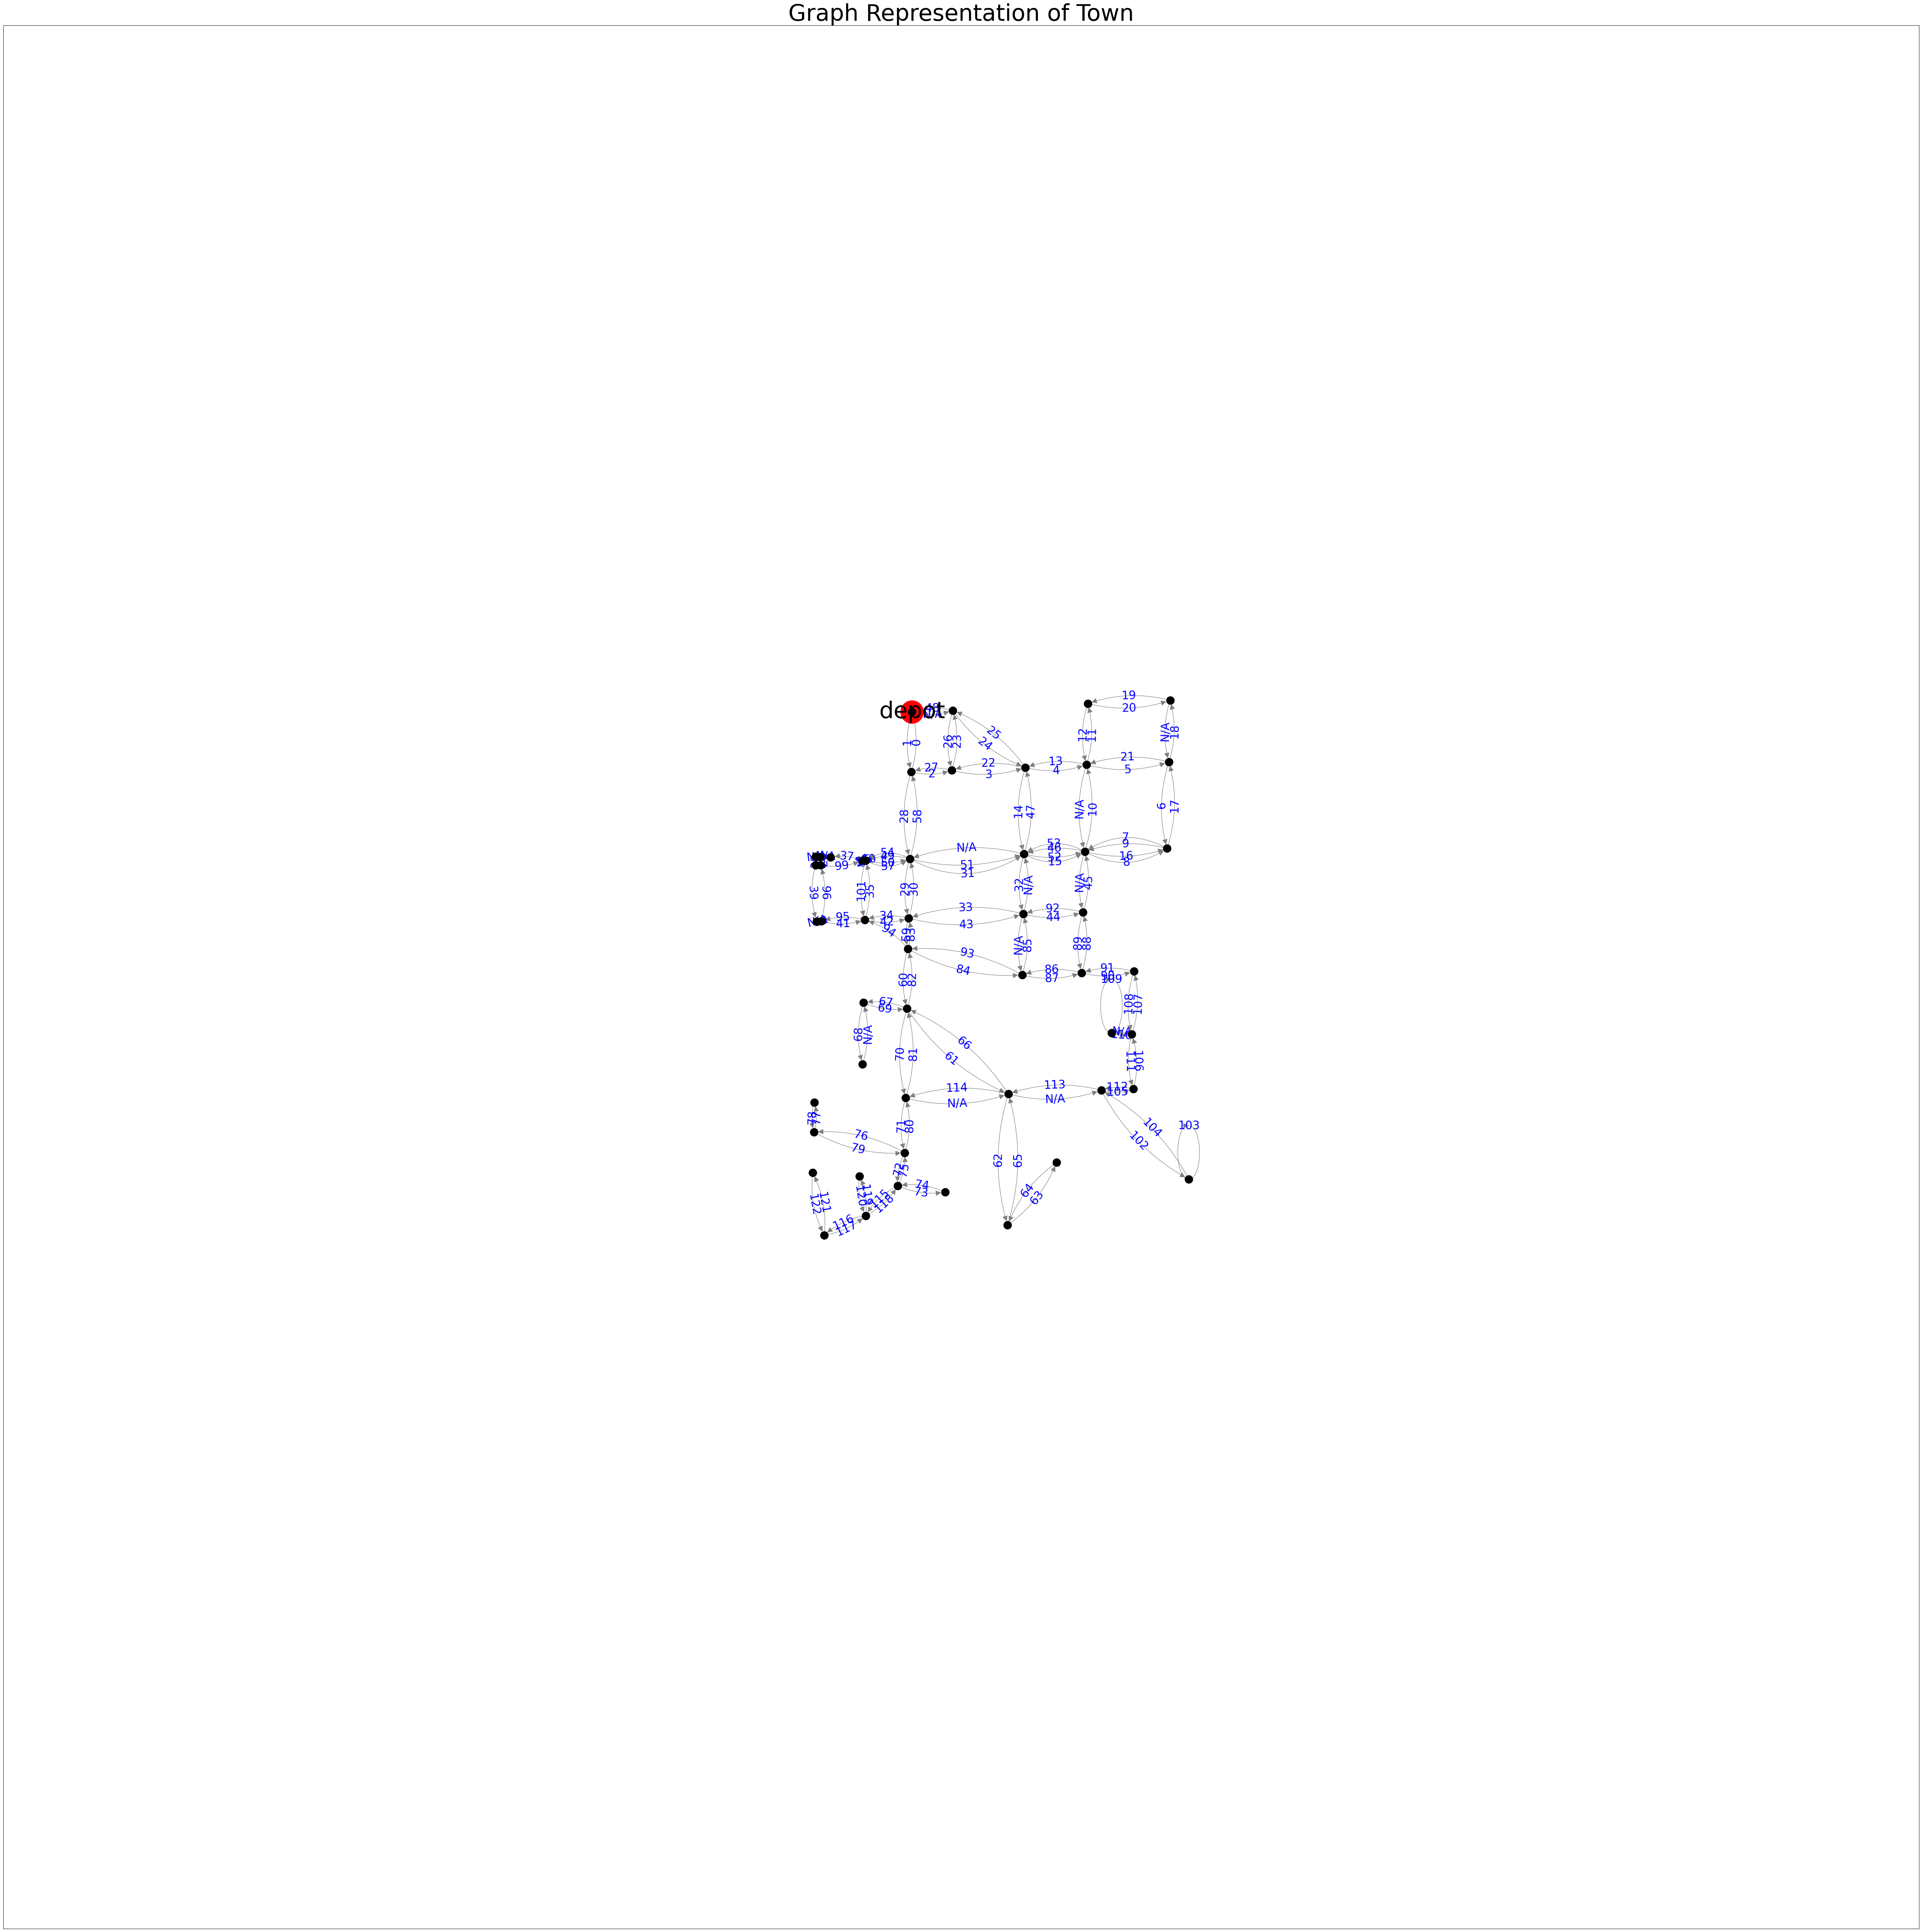

DONE
Routes cost 1359.29835


In [16]:

# 5. Plot final routes
G_graph = plotting.add_order_attribute(G, sol.routes)
plotting.draw_labeled_multigraph(G_graph, 'order', size=(75,75), plotDepot=True)

print("DONE")
print("Routes cost", sol.cost)

## Plot the routes using Folium

In [18]:
def create_full_routes_with_returns(G: nx.MultiDiGraph, sp: ShortestPaths, routes: list[list[tuple[int, int, int]]], DEPOT: int) -> list[tuple[int, int, int]]:
    """
    Create full routes with returns to the depot when salt runs out.

    This function generates a complete route for snowplowing, ensuring that the 
    snowplow returns to the depot to refill salt when it runs out. It uses the 
    shortest paths to navigate between edges and the depot.

    Args:
        G (nx.MultiDiGraph): The graph representing the road network.
        sp (ShortestPaths): An object that provides shortest path calculations.
        routes (list[list[tuple[int, int, int]]]): A list of routes, where each route 
            is a list of edges represented as tuples (start_node, end_node, key).
        DEPOT (int): The node representing the depot location.

    Returns:
        list[tuple[int, int, int]]: A list of edges representing the full route, including returns to the depot when salt runs out.
    """
    
    full_route = list()
    salt_val = params.SALT_CAP
    for i in range(len(routes)):
        for j in range(len(routes[i])):
            edge = routes[i][j]
            edge_data = G.get_edge_data(edge[0], edge[1], edge[2])

            # check to see if salt runs out
            if salt_val - edge_data['salt_per'] < 0:
                print("Returning to depot")
                path = sp.get_shortest_path(edge, (DEPOT, DEPOT, 0))
                full_route.extend(path)
                salt_val = params.SALT_CAP
                continue

            salt_val -= edge_data['salt_per']
            if j == 0:
                path = sp.get_shortest_path((DEPOT, DEPOT, 0), edge)
                full_route.extend(path)
            elif j+1 < len(routes[i]):
                next_edge = routes[i][j+1]
                if edge[1] == next_edge[0]:
                    full_route.append(edge)
                else:
                    path = sp.get_shortest_path(edge, next_edge)
                    full_route.extend(path)
                    full_route.pop()
            else:
                print("Returning home at the end of a route")
                path = sp.get_shortest_path(edge, (DEPOT, DEPOT, 0))
                full_route.extend(path)
                if i != len(routes)-1:
                    full_route.pop() # remove the depot node at the end if there is more to come (because it will be double-counted)
    return full_route            
full_route = create_full_routes_with_returns(G, sp, sol.routes, DEPOT)
print(len(G.edges))

Returning home at the end of a route
137


## Algorithm to draw linestrings

1. Have a fixed difference between lat long coords to accept
2. Loop through the coords of the linestring.
    - If the difference is smaller than the desired, continue
    - Otherwise use Numpy to artificially add coords the linestring
3. Add each individual time to individual coords on the linestring so that it is a smooth animation


In [ ]:
def find_pairs_of_edges(G: nx.MultiDiGraph) -> tuple[dict[tuple[tuple[int, int, int], tuple[int,int,int]]], dict[tuple[tuple[int, int, int], tuple[int,int,int]]]]:
    """
    Find pairs of edges in a graph that represent the same road segment in opposite directions, and find 
    pairs of edges that represent the same road segment in the same direction.

    Helper function for plot_moving_routes_folium.

    Args:
        G (nx.MultiDiGraph): The graph representing the road network.
    Returns:
        tuple[dict[tuple[tuple[int, int, int], tuple[int,int,int]]], dict[tuple[tuple[int, int, int], tuple[int,int,int]]]]
        A tuple of two dictionaries mapping edges in a pair or an antipair to each other. 
        The first dictionary contains pairs of edges that represent the same road segment in the same direction, 
        and the second dictionary contains pairs of edges that represent the same road segment in opposite directions
    """
    lstrings = dict() # dictionary mapping linestrings to edges
    pairs_dict = dict() # dict mapping edge to its pair. Each edge is marked both as a key and a value
    antipairs_dict = dict()
    for edge in G.edges(data=True, keys=True):
        edge_tup = (edge[0], edge[1], edge[2])
        if edge[3]['geometry'] is not None:
            lstring = tuple(edge[3]['geometry'].coords)
            # matching pair
            if lstring in lstrings.keys():
                pairs_dict.update({edge_tup: lstrings[lstring]})
                pairs_dict.update({lstrings[lstring]: edge_tup})
                # lstrings.pop(lstring)

            # matching antipair (same road, opposite direction)
            if lstring[::-1] in lstrings.keys():
                antipairs_dict.update({edge_tup: lstrings[lstring[::-1]]})
                antipairs_dict.update({lstrings[lstring[::-1]]: edge_tup})
            
            lstrings.update({lstring: edge_tup})

    return pairs_dict, antipairs_dict
find_pairs_of_edges(G)

({(20, 53, 1): (20, 53, 0),
  (20, 53, 0): (20, 53, 1),
  (33, 32, 1): (33, 32, 0),
  (33, 32, 0): (33, 32, 1),
  (14, 53, 1): (14, 53, 0),
  (14, 53, 0): (14, 53, 1),
  (14, 33, 1): (14, 33, 0),
  (14, 33, 0): (14, 33, 1),
  (53, 20, 1): (53, 20, 0),
  (53, 20, 0): (53, 20, 1),
  (53, 14, 1): (53, 14, 0),
  (53, 14, 0): (53, 14, 1),
  (28, 32, 1): (28, 32, 0),
  (28, 32, 0): (28, 32, 1),
  (32, 28, 1): (32, 28, 0),
  (32, 28, 0): (32, 28, 1),
  (32, 33, 1): (32, 33, 0),
  (32, 33, 0): (32, 33, 1)},
 {(4, 3, 0): (3, 4, 0),
  (3, 4, 0): (4, 3, 0),
  (34, 3, 0): (3, 34, 0),
  (3, 34, 0): (34, 3, 0),
  (5, 4, 0): (4, 5, 0),
  (4, 5, 0): (5, 4, 0),
  (36, 4, 0): (4, 36, 0),
  (4, 36, 0): (36, 4, 0),
  (6, 5, 0): (5, 6, 0),
  (5, 6, 0): (6, 5, 0),
  (9, 36, 0): (36, 9, 0),
  (36, 9, 0): (9, 36, 0),
  (9, 5, 0): (5, 9, 0),
  (5, 9, 0): (9, 5, 0),
  (7, 6, 0): (6, 7, 0),
  (6, 7, 0): (7, 6, 0),
  (10, 9, 0): (9, 10, 0),
  (9, 10, 0): (10, 9, 0),
  (10, 6, 0): (6, 10, 0),
  (6, 10, 0): (10, 6,

Graphing algorithm:
- go through each edge of the graph
- if it's the first time traversing the pair, mark it with a thinner line
    - when completing the pair, mark it with a thicker line
- if it's the first time traversing the antipair, mark it with a dash
    - when completing the antipair, mark it with a solid line

what if an edge should belong to both a pair and an antipair?

In [22]:
def lengthen_lstring_coords(lstring: shapely.LineString, diff: float) -> list[tuple[float, float]]:
    """
    Get the coordinates of a LineString with additional points added to make the lines smoother.

    Helper function for plot_moving_routes_folium.

    Args:
        lstring (shapely.LineString): The LineString to get coordinates from.
        diff (float): The maximum difference between two points in the LineString.
    Returns:
        list[tuple[float, float]]: A list of coordinates for the LineString.
    """
    lat_long_coords = [(y, x) for x, y in lstring.coords]
    lstring_lengthed_coords = list()
    for i in range(len(lat_long_coords)):
        lat,long=lat_long_coords[i]
        if i < len(lat_long_coords) - 1:
            next_lat, next_long = lat_long_coords[i + 1]
            dif_lat, dif_long = next_lat - lat, next_long - long

            if dif_lat > diff or dif_long > diff:
                num_intervals = int(max(abs(dif_lat), abs(dif_long)) // diff)
                new_lat_coords = np.linspace(lat, next_lat, num_intervals)
                new_long_coords = np.linspace(long, next_long, num_intervals)

                lstring_lengthed_coords.extend([(new_long_coords[i], new_lat_coords[i]) for i in range(num_intervals)])
            else:
                lstring_lengthed_coords.append((long, lat))
        else:
            lstring_lengthed_coords.append((long, lat))
    return lstring_lengthed_coords, lat_long_coords

def plot_moving_routes_folium(G: nx.MultiDiGraph, full_route: list[tuple[int, int, int]], m: folium.Map | None, label_color: str, path_color: str, dif=1e-4) -> folium.Map:
    """
    Plots moving routes on an animated Folium map.

    Args:
        G (nx.MultiDiGraph): The graph containing the route data.
        full_route (list[tuple[int, int, int]]): A list of tuples representing the edges in the route.
        m (folium.Map | None): An existing Folium map to plot on, or None to create a new map.
        label_color (str): The color of the labels for the markers.
        path_color (str): The color of the path lines.
    Returns:
        folium.Map: The Folium map with the plotted routes.
    """
    G_copy = G.copy()
    if m is None:
        m = folium.Map(location=[43.1, -89.5], zoom_start=12)
    count = 0
    current_time = datetime.datetime.now()
    features = list()

    pairs_dict, antipairs_dict = find_pairs_of_edges(G)
    partially_mapped_pairs, partially_mapped_antipairs = set(), set()

    serviced_edges = set()
    for edge in full_route:
        edge_data = G_copy.get_edge_data(edge[0], edge[1], edge[2])   
        if edge_data is None:
            continue
        
        graph_attributes = {"color": path_color, "dashed": False, "weight": 5}
        # if the edge is a part of a pair
        if edge in pairs_dict.keys():
            # if the first part of the edge hasn't been serviced, make the line thinner
            if edge not in partially_mapped_pairs and pairs_dict[edge] not in partially_mapped_pairs:
                graph_attributes['weight'] = 1
                partially_mapped_pairs.add(edge)
        if edge in antipairs_dict.keys():
            # if the first part of the edge hasn't been serviced, make the line dashed
            if edge not in partially_mapped_antipairs and antipairs_dict[edge] not in partially_mapped_antipairs:
                graph_attributes['dashed'] = True
                partially_mapped_antipairs.add(edge)

            
        deadhead = False if edge not in serviced_edges else True
        serviced_edges.add(edge)

        name = edge_data.get("name", "Unnamed")
        if deadhead:
            graph_attributes['color'] = "red"

        lstring = edge_data['geometry']
        coords, lat_long_coords = lengthen_lstring_coords(lstring, dif)
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": coords
            },
            "properties": {
                "times": [str(current_time + datetime.timedelta(minutes=i)) for i in range(len(coords))],
                "name": name,
                "edge": edge,
                "order": count,
                "style": {
                    "color": graph_attributes["color"],
                    "weight": graph_attributes['weight'],
                    "dashArray": "5, 10" if graph_attributes['dashed'] else None
                },
            }
        }
        features.append(feature)
        folium.PolyLine(locations=lat_long_coords, color="black", weight=.5, tooltip=edge_data).add_to(m)
        current_time += datetime.timedelta(minutes=len(coords))
    folium.plugins.TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT5M",
        add_last_point=False,
    ).add_to(m)
    folium.plugins.TimestampedGeoJson(
        {
            "type": "FeatureCollection",
            "features": features,
        },
        period="PT5M",
        add_last_point=True,
        duration="PT1M"
    ).add_to(m)
    return m
# plot_moving_routes_folium(G, full_route, label_color="blue", path_color="blue", m=None)

NameError: name 'shapely' is not defined

The reason some of the antipairs are still dashed is because of the construction of the graph. Randomly selected 10% of edges to be not serviced, so some of the corresponding edges in a couple antipairs aren't ever serviced.

In [24]:
original_full_route = create_full_routes_with_returns(G, sp, rreq, DEPOT)
plotting.plot_moving_routes_folium(G, original_full_route, label_color="green", path_color="green", m=None)

Heuristics to implement:
- Go straight as long as possible if its unserviced
- If we hit an unserviced edge at an intersection, we should do everything we can to turn onto that road to service it
- Basically completely prohibit u-turns

Cost function adjustments:
- Rewarding straights and penalizing u-turns
- Penalizing any deadheading (we want to avoid as much as possible!)
